## Loading data

In [1]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
import json
from pprint import pprint
from time import time, strftime, gmtime

import warnings
warnings.filterwarnings("ignore", ".*does not have many workers.*")

In [2]:
# helper function for data visualization
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()

## Dataloader

In [3]:
from torch.utils.data import DataLoader
from torch.utils.data import Dataset as BaseDataset

In [4]:
class Dataset(BaseDataset):
    def __init__(self, data, data_path, augmentation=None, preprocessing=None):
        self.data = data
        self.data_path = data_path
        self.augmentation = augmentation
        self.preprocessing = preprocessing
        self.jpeg_thresh = 0.4

    def __getitem__(self, i):
        record = self.data[i]
        image = np.expand_dims(cv2.imread(os.path.join(self.data_path, 'seis', record['data']), cv2.IMREAD_GRAYSCALE), axis=0)
        mask = cv2.imread(os.path.join(self.data_path, 'fault', record['label']), cv2.IMREAD_GRAYSCALE)
        mask[mask > self.jpeg_thresh * 255] = 255
        mask[mask <= self.jpeg_thresh * 255] = 0
        mask = np.expand_dims(mask, axis=0) / 255

        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']

        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']

        return {"image":image, "mask": mask}

    def __len__(self):
        return len(self.data)

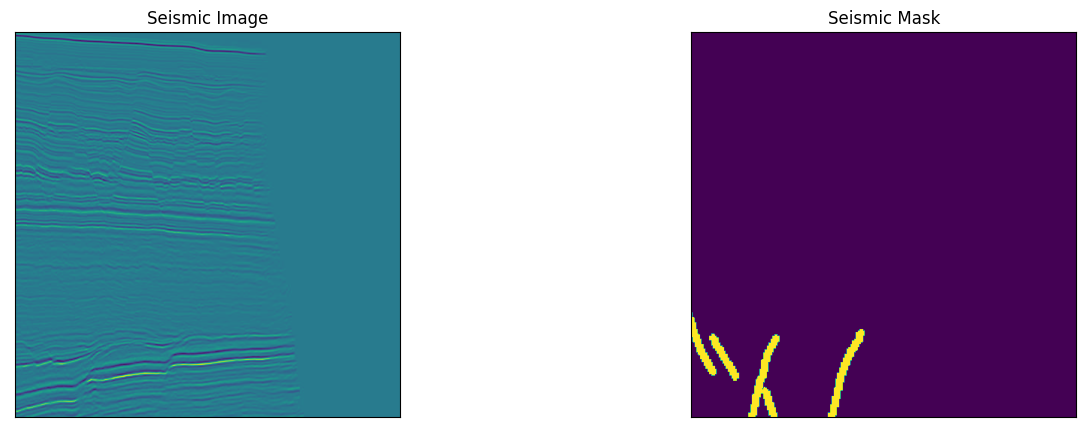

In [5]:
data_dir = os.path.join('data', '512window')
train_dir = os.path.join(data_dir, 'train')
test_dir = os.path.join(data_dir, 'eval')

with open(os.path.join(train_dir, 'metadata.json'), 'r') as file:
    train_list = json.load(file)
with open(os.path.join(test_dir, 'metadata.json'), 'r') as file:
    test_list = json.load(file)

# Lets look at data we have
dataset = Dataset(train_list, train_dir)

sample = dataset[4] # get some sample
image, mask = sample["image"][0], sample["mask"][0]
visualize(
    seismic_image=image,
    seismic_mask=mask.squeeze(),
)

## Augmentations

In [6]:
import albumentations as albu

def get_training_augmentation():
    train_transform = [
        albu.HorizontalFlip(p=0.5)
    ]
    return albu.Compose(train_transform)

def get_validation_augmentation():
    test_transform = [
    ]
    return albu.Compose(test_transform)

## Create model and train

### Learning functions

In [7]:
import torch
import numpy as np
import segmentation_models_pytorch as smp
import pytorch_lightning as pl
from pytorch_lightning.loggers import TensorBoardLogger

In [8]:
def show_test_images(model, test_loader):
    batch = next(iter(test_loader))
    with torch.no_grad():
        model.eval()
        logits = model(batch['image'].float())
    pr_masks = logits.sigmoid()

    for image, gt_mask, pr_mask in zip(batch['image'], batch['mask'], pr_masks):
        plt.figure(figsize=(10, 5))

        plt.subplot(1, 3, 1)
        plt.imshow(image.numpy().squeeze())
        plt.title("Image")
        plt.axis("off")

        plt.subplot(1, 3, 2)
        plt.imshow(gt_mask.numpy().squeeze())
        plt.title("Ground truth")
        plt.axis("off")

        plt.subplot(1, 3, 3)
        plt.imshow(pr_mask.numpy().squeeze())
        plt.title("Prediction")
        plt.axis("off")

        plt.show()

In [9]:
class FaultModel(pl.LightningModule):
    def __init__(self, arch, encoder_name, encoder_weights, in_channels, out_classes, **kwargs):
        super().__init__()
        self.model = smp.create_model(
            arch, encoder_name=encoder_name, encoder_weights=encoder_weights, in_channels=in_channels, classes=out_classes, **kwargs
        )
        self.in_channels = in_channels

        if in_channels == 3:
            # preprocessing parameteres for image
            params = smp.encoders.get_preprocessing_params(encoder_name)
            self.register_buffer("std", torch.tensor(params["std"]).view(1, 3, 1, 1))
            self.register_buffer("mean", torch.tensor(params["mean"]).view(1, 3, 1, 1))

        # for image segmentation dice loss could be the best first choice
        self.loss_fn = smp.losses.DiceLoss(smp.losses.BINARY_MODE, from_logits=True)
        self.save_hyperparameters()

    def forward(self, image):
        if self.in_channels == 3:
            # normalize image here
            image = (image - self.mean) / self.std
        mask = self.model(image)
        return mask

    def shared_step(self, batch, stage):

        image = batch["image"].float()
        # Shape of the image should be (batch_size, num_channels, height, width)
        assert image.ndim == 4
        # Check that image dimensions are divisible by 32
        h, w = image.shape[2:]
        assert h % 32 == 0 and w % 32 == 0

        mask = batch["mask"].float()
        # Shape of the mask should be [batch_size, num_classes, height, width]
        assert mask.ndim == 4
        # Check that mask values in between 0 and 1, NOT 0 and 255 for binary segmentation
        assert mask.max() <= 1.0 and mask.min() >= 0

        logits_mask = self.forward(image)

        # Predicted mask contains logits, and loss_fn param `from_logits` is set to True
        loss = self.loss_fn(logits_mask, mask)

        # Lets compute metrics for some threshold
        # first convert mask values to probabilities, then
        # apply thresholding
        prob_mask = logits_mask.sigmoid()
        pred_mask = (prob_mask > 0.5).float()

        # Compute IoU metric
        # compute true positive, false positive, false negative and
        # true negative 'pixels' for each image and class
        tp, fp, fn, tn = smp.metrics.get_stats(pred_mask.long(), mask.long(), mode="binary")

        return {
            "loss": loss,
            "tp": tp,
            "fp": fp,
            "fn": fn,
            "tn": tn,
        }

    def shared_epoch_end(self, outputs, stage):
        # aggregate step metics
        tp = torch.cat([x["tp"] for x in outputs])
        fp = torch.cat([x["fp"] for x in outputs])
        fn = torch.cat([x["fn"] for x in outputs])
        tn = torch.cat([x["tn"] for x in outputs])

        # per image IoU means that we first calculate IoU score for each image
        # and then compute mean over these scores
        per_image_iou = smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro-imagewise")

        # dataset IoU means that we aggregate intersection and union over whole dataset
        # and then compute IoU score. The difference between dataset_iou and per_image_iou scores
        # in this particular case will not be much, however for dataset
        # with "empty" images (images without target class) a large gap could be observed.
        # Empty images influence a lot on per_image_iou and much less on dataset_iou.
        dataset_iou = smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro")

        metrics = {
            f"{stage}_per_image_iou": per_image_iou,
            f"{stage}_dataset_iou": dataset_iou,
        }

        self.log_dict(metrics, prog_bar=True)

    def training_step(self, batch, batch_idx):
        return self.shared_step(batch, "train")

    def training_epoch_end(self, outputs):
        return self.shared_epoch_end(outputs, "train")

    def validation_step(self, batch, batch_idx):
        return self.shared_step(batch, "valid")

    def validation_epoch_end(self, outputs):
        return self.shared_epoch_end(outputs, "valid")

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=0.001)

In [10]:
train_dataset = Dataset(
    train_list,
    train_dir,
    augmentation=get_training_augmentation()
)
test_dataset = Dataset(
    test_list,
    test_dir,
)

BATCH_SIZE = 2
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [11]:
trainer = pl.Trainer(
    accelerator='gpu',
    devices=1,
    max_epochs=20,
    logger=TensorBoardLogger(save_dir="")
)
# model = FaultModel("FPN", "resnet50", in_channels=1, out_classes=1)
# checkpoint = torch.load(os.path.join('lightning_logs', 'version_0', 'checkpoints', 'epoch=99-step=7000.ckpt'))
# model.load_state_dict(checkpoint['state_dict'])

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Missing logger folder: lightning_logs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type          | Params
------------------------------------------
0 | model   | DeepLabV3Plus | 11.7 M
1 | loss_fn | DiceLoss      | 0     
------------------------------------------
11.7 M    Trainable params
0         Non-trainable params
11.7 M    Total params
46.718    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=20` reached.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


01h:23m:14s


Validation: 0it [00:00, ?it/s]

[{'valid_dataset_iou': 0.54201740026474,
  'valid_per_image_iou': 0.547175943851471}]


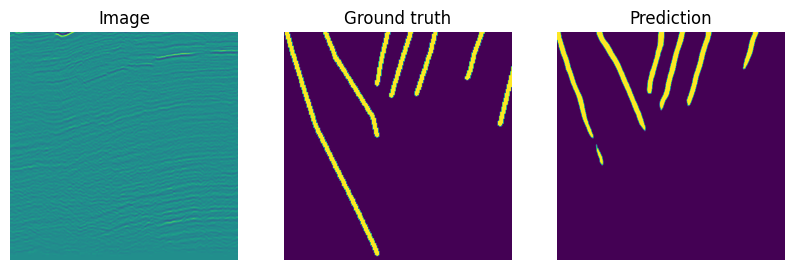

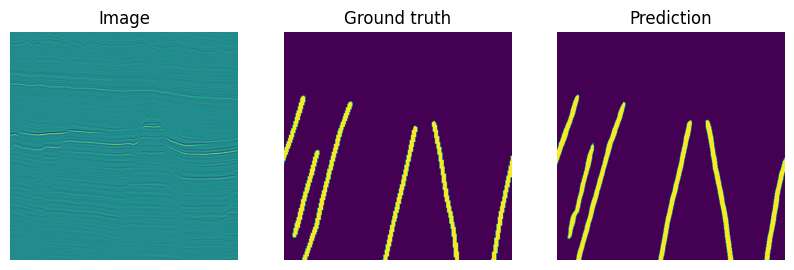

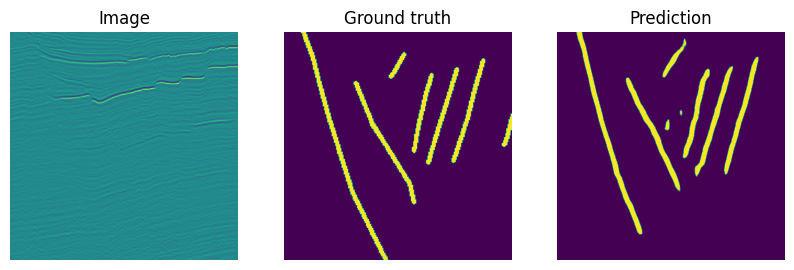

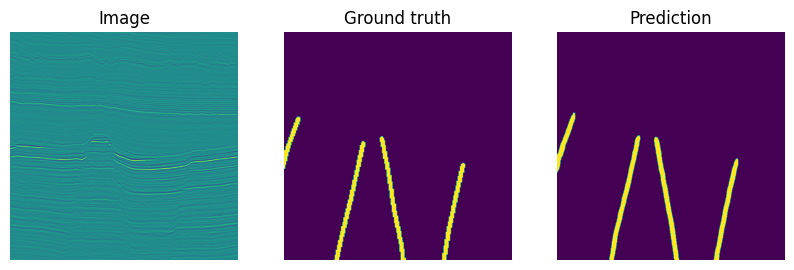

In [12]:
model = FaultModel("DeepLabV3plus", "efficientnet-b3", 'imagenet', in_channels=1, out_classes=1)
# batch_size = 4
start_time = time()
trainer.fit(
    model,
    train_dataloaders=train_loader,
    val_dataloaders=test_loader,
)
end_time = time()
print(strftime('%Hh:%Mm:%Ss', gmtime(end_time - start_time)))
valid_metrics = trainer.validate(model, dataloaders=test_loader, verbose=False)
pprint(valid_metrics)
show_test_images(model, test_loader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type          | Params
------------------------------------------
0 | model   | DeepLabV3Plus | 42.0 M
1 | loss_fn | DiceLoss      | 0     
------------------------------------------
42.0 M    Trainable params
0         Non-trainable params
42.0 M    Total params
167.880   Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=20` reached.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


04h:02m:33s


Validation: 0it [00:00, ?it/s]

[{'valid_dataset_iou': 0.5052517056465149,
  'valid_per_image_iou': 0.5034997463226318}]


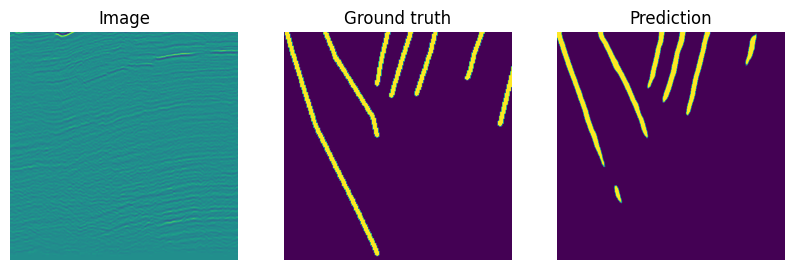

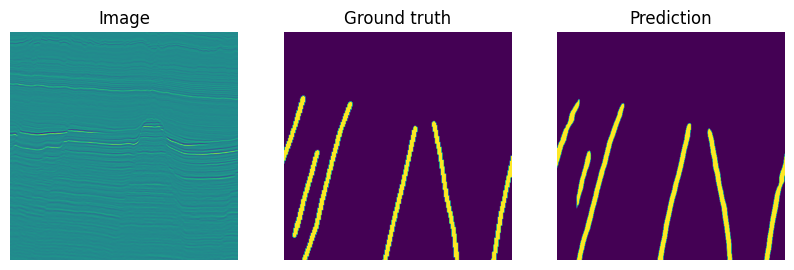

In [12]:
model = FaultModel("DeepLabV3plus", "efficientnet-b6", 'imagenet', in_channels=1, out_classes=1)
# batch_size = 2
start_time = time()
trainer.fit(
    model,
    train_dataloaders=train_loader,
    val_dataloaders=test_loader,
)
end_time = time()
print(strftime('%Hh:%Mm:%Ss', gmtime(end_time - start_time)))
valid_metrics = trainer.validate(model, dataloaders=test_loader, verbose=False)
pprint(valid_metrics)
show_test_images(model, test_loader)